### **Regression by Prophet**
make uncertainty prediction by Prophet regression

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000
from tqdm import tqdm

from myConfig import *
import gc
from myUtils import *
from myProphet import *

In [2]:
data_path = os.path.join("mydata","agg_train_val.pickle")
data = pd.read_pickle(data_path)

cols = [c for c in data.columns if "d_" in c]
data = data[cols]
data = data.T
data.index.name = "d"
data = data.reset_index()

print("**** aggregated train_data ****")
data

**** aggregated train_data ****


,d,Total_X,CA_X,TX_X,WI_X,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
0,d_1,32631,14195,9438,8998,4337,3494,4739,1625,2556,...,0,0,0,0,0,0,2,0,0,0
1,d_2,31749,13805,9630,8314,4155,3046,4827,1777,2687,...,1,0,1,0,0,1,0,0,0,1
2,d_3,23783,10108,6778,6897,2816,2121,3785,1386,1822,...,0,0,0,0,0,0,0,0,0,0
3,d_4,25412,11047,7381,6984,3051,2324,4232,1440,2258,...,0,0,1,0,0,0,0,1,0,1
4,d_5,19146,9925,5912,3309,2630,1942,3817,1536,1694,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,35343,15148,9600,10595,3722,3691,5235,2500,2901,...,0,0,0,0,0,1,0,0,0,0
1909,d_1910,35033,14488,9602,10943,3709,3303,5018,2458,2776,...,1,0,0,0,0,0,0,0,1,0
1910,d_1911,40517,17095,10615,12807,4387,4457,5623,2628,3022,...,1,0,0,0,0,0,0,0,0,0
1911,d_1912,48962,21834,12266,14862,5577,5884,7419,2954,3700,...,0,0,0,0,0,0,0,0,0,0


#### **日にち情報付与**

In [3]:
calendar = pd.read_csv(os.path.join("rawdata","calendar.csv"),parse_dates=[0])
print("**** calendar ****")
display(calendar.head(5))
print()

data = pd.merge(data,calendar[["d","date"]],on="d",how="left")
data = data.set_index("date",drop=True)
data = data.drop(columns={"d"})
print("**** calendar ****")
display(data.head(5))

**** calendar ****


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1



**** calendar ****


,Total_X,CA_X,TX_X,WI_X,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,TX_2_X,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,3852,...,0,0,0,0,0,0,2,0,0,0
2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,3937,...,1,0,1,0,0,1,0,0,0,1
2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,2731,...,0,0,0,0,0,0,0,0,0,0
2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,2954,...,0,0,1,0,0,0,0,1,0,1
2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,2492,...,1,0,0,0,0,0,0,0,0,0


### **Prophet Regression**
https://facebook.github.io/prophet/docs/quick_start.html

In [4]:
# Forecast days
import datetime as dt
start = dt.datetime(2016,4,25)
end = start + dt.timedelta(days=27)

print("Forecast ",start,"<->",end)

Forecast  2016-04-25 00:00:00 <-> 2016-05-22 00:00:00


#### **Prophetの回帰テスト, 可視化**

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


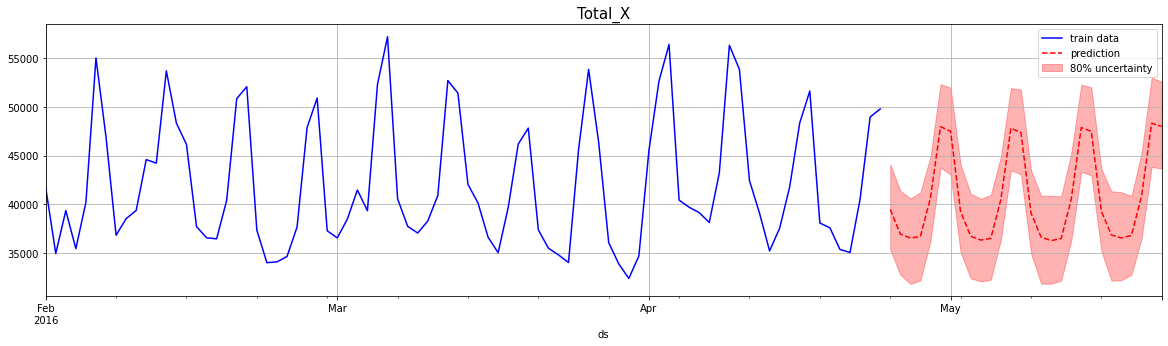

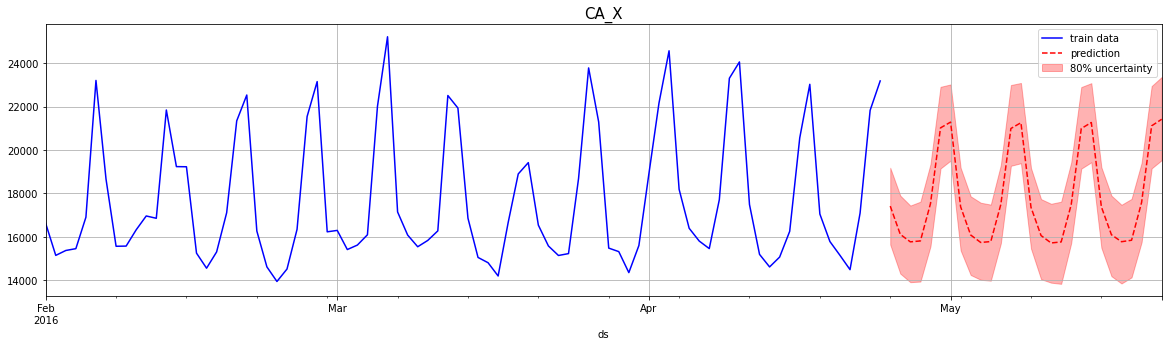

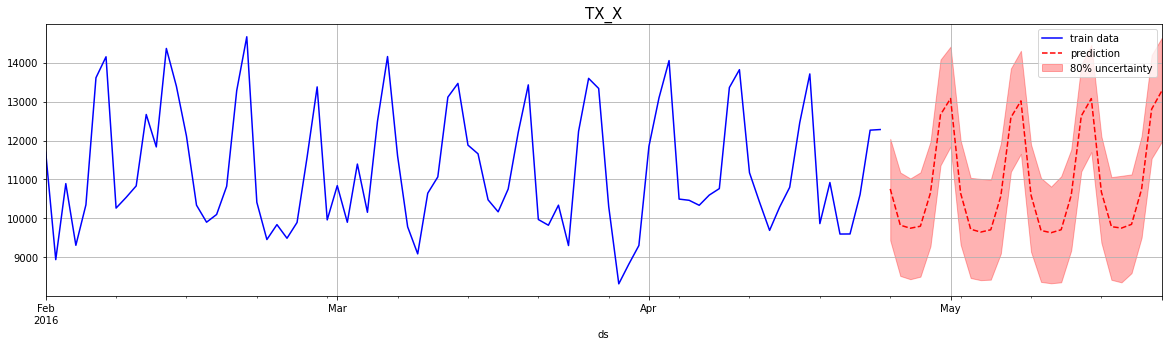

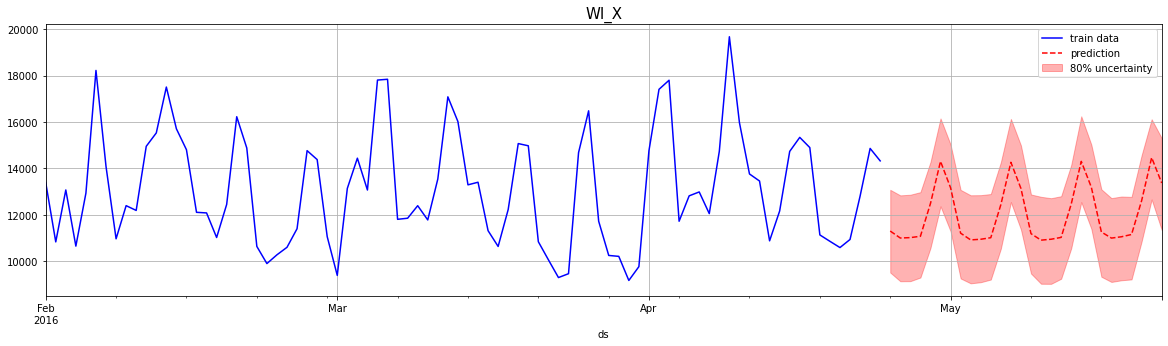

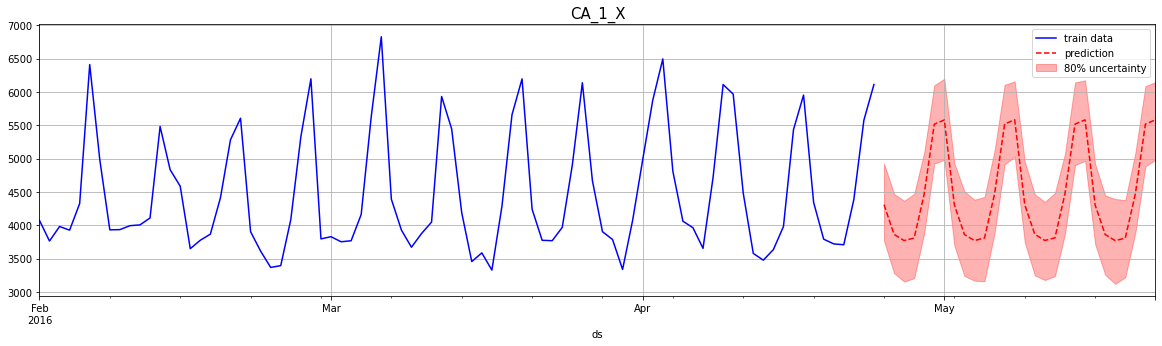

In [5]:
mean = pd.DataFrame()

for col in data.columns[:5]:
    
    ts = data[col]
    
    model = myProphet()
    model.fit(y=ts)
    pred,unc = model.predict(start=start,end=end,freq="1D",mode="uncertainty")
    
    # prophet使うときはこれがいる
    pd.plotting.register_matplotlib_converters()
    
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    ax.set_title(col,fontsize=15)
    
    ts[-28*3:].plot(style="b-",label="train data",ax=ax)
    pred.plot(style="r--",label="prediction",ax=ax)
    ax.fill_between(x=pred.index,
                    y1=unc["upper"].values,
                    y2=unc["lower"].values,
                    color="red",
                    alpha=0.3,label="80% uncertainty")
    
    ax.legend()
    ax.grid(True)
    
    plt.show()